# Formas de Discretizar Espacios Continuos

En este notebook se muestra como adaptar los espacios de estados continuos para que se puedan aplicar los métodos tabulares de aprendizaje por refuerzo.


## Preparamos el entorno que se usará en el notebook


In [104]:
#@title Importamos las librerias necesarias
import random
import gymnasium as gym
from gymnasium import ObservationWrapper
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [105]:
#@title Cargamos el entorno
env = gym.make("MountainCar-v0", render_mode="rgb_array")
env.reset(seed=100)


(array([-0.43300366,  0.        ], dtype=float32), {})

### **Las acciones del entorno**

La acciones disponibles son:
- 0: Acelerar a la izquierda.
- 1: No acelerar
- 2: Acelerar a la derecha

In [3]:
env.action_space

Discrete(3)

### **Los estados del entorno**

Las observaciones es un ndarray con dimensión (2,) donde los elementos se corresponde a los siguientes valores:

| Número | Observación                          | Mínimo | Máximo | Unidad        |
|--------|--------------------------------------|--------|--------|---------------|
| 0      | Posición del coche en el eje x      | -1.2   | 0.6    | posición (m)  |
| 1      | Velocidad del coche                 | -0.07  | 0.07   | velocidad (v) |


In [4]:
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

## Agregación

Podemos pasar de un espacio continuo de observaciones $[-1.2, 0.6]\times [-0.07, 0.07]$ a un espacio discreto. Para ello, discretizamos cada dimensión con una partición de intervalos. A esto se le llama **agregación.**


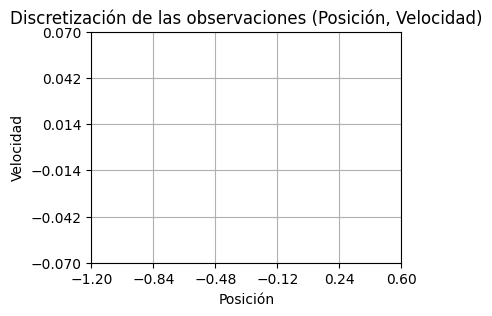

In [5]:
#@title Por ejemplo, podemos discretizar el espacio en solo 25 observaciones
# Definir los rangos para la posición y la velocidad
x_min, x_max = -1.2, 0.6    # Rango para la posición (eje X)
y_min, y_max = -0.07, 0.07  # Rango para la velocidad (eje Y)

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(4, 3))

# Establecer los límites de los ejes
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Dividir el eje X en 5 partes (6 ticks) y el eje Y en 5 partes (6 ticks)
x_ticks = np.linspace(x_min, x_max, 6)
y_ticks = np.linspace(y_min, y_max, 6)

# Asignar los ticks a los ejes
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

# Activar la grilla para mostrar las divisiones
ax.grid(True)

# Etiquetas y título para la gráfica
ax.set_xlabel("Posición")
ax.set_ylabel("Velocidad")
ax.set_title("Discretización de las observaciones (Posición, Velocidad)")

# Mostrar la gráfica
plt.show()

### Creamos *una* agregación de estados

- Necesitamos hacer un Wrapper sobre el espacio de observaciones
- Vamos a discritizar para trabajar con 400 estados

In [106]:
#@title Extensión de la calse ObservationWrapper de Gymnasium para discretizar estados continuos

# https://gymnasium.farama.org/tutorials/gymnasium_basics/implementing_custom_wrappers/


# Definimos una clase que hereda de gym.ObservationWrapper, la cual nos permite modificar las observaciones que devuelve el entorno.
class StateAggregationEnv(gym.ObservationWrapper):


    def __init__(self, env, bins, low, high):
        # Constructor de la clase. Recibe:
        # - env: el entorno original de Gym que se va a envolver.
        # - bins: un array (o lista) que indica el número de intervalos (o "cubos") para discretizar en cada dimensión.
        # - low: los valores mínimos para cada dimensión de la observación.
        # - high: los valores máximos para cada dimensión de la observación.
        # Llamamos al constructor de la clase padre (ObservationWrapper) pasando el entorno original.
        super().__init__(env)  # Hay que invocar siempre al super()

        # En el caso del coche:
        # low=[-1.2, -0.07], high=[0.6, 0.7], bins=[20, 20]

        # Creamos "cubos" o "buckets" para cada dimensión.
        # Usamos np.linspace para generar una secuencia de números entre el valor mínimo (j) y el valor máximo (k)
        # Se crean (l - 1) divisiones, donde l es el número de bins especificados para esa dimensión.
        # La función zip(low, high, bins) recorre en paralelo cada valor mínimo, máximo y cantidad de bins.
        self.buckets = [np.linspace(j, k, l - 1) for j, k, l in zip(low, high, bins)]

        # En el caso del coche, habrá "2 linspace (arrays)"
        # Un array es [-1.2, -1,1, ...., 0.5, 0.6] Con 20 valores
        # Otro array es [-0.07, -0.06, ..., 0.06, 0.07]  Con 20 valores

        # Definimos el espacio de observación discreto. Usamos gym.spaces.MultiDiscrete,
        # el cual define un espacio de observaciones con múltiples dimensiones discretas.
        # MultiDiscrete es un producto cartesiano de distintos espacios discretos. Aquí aplicamos dos.
        # nvec toma como argumento un vector o lista con el número de valores discretos que habrá en cada dimensión.
        # Convertimos bins a lista.
        self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist())

    # Método que se encarga de transformar la observación continua del entorno original
    # a una observación discretizada según los "cubos" definidos.
    def observation(self, obs):  # Hay  que sobreescribir necesariamente este método.
        # Para cada dimensión de la observación, usamos np.digitize para encontrar en qué intervalo (bucket) cae el valor.
        # np.digitize devuelve el índice del cubo al que pertenece el valor.
        # La función zip(obs, self.buckets) recorre cada valor de la observación y su correspondiente bucket.
        indices = tuple(np.digitize(i, b) for i, b in zip(obs, self.buckets))

        # Retornamos la tupla de índices, que representa el estado discretizado.
        return indices


In [7]:
#@title Dividimos cada dimensión en 20 intervalos. Al nuevo espacio lo llamaremos *saenv*

bins = np.array([20, 20])
low = env.observation_space.low
high = env.observation_space.high
saenv = StateAggregationEnv(env, bins=bins, low=low, high=high)
saenv.buckets

[array([-1.20000005, -1.10000004, -1.00000004, -0.90000004, -0.80000003,
        -0.70000003, -0.60000002, -0.50000002, -0.40000002, -0.30000001,
        -0.20000001, -0.1       ,  0.        ,  0.1       ,  0.20000001,
         0.30000001,  0.40000002,  0.50000002,  0.60000002]),
 array([-0.07      , -0.06222222, -0.05444444, -0.04666667, -0.03888889,
        -0.03111111, -0.02333333, -0.01555556, -0.00777778,  0.        ,
         0.00777778,  0.01555556,  0.02333333,  0.03111111,  0.03888889,
         0.04666667,  0.05444444,  0.06222222,  0.07      ])]

### Comparamos el entorno original con el entorno con estados agregados

In [107]:
print(f"El espacio de observaciones original es: {env.observation_space}, \n\
Un estado para este espacio es: {env.observation_space.sample()}")
print(f"El espacio de estados modificado es: {saenv.observation_space}, \n\
Un estado para este espacio es: {saenv.observation_space.sample()}")

El espacio de observaciones original es: Box([-1.2  -0.07], [0.6  0.07], (2,), float32), 
Un estado para este espacio es: [-0.67068034 -0.05055468]
El espacio de estados modificado es: MultiDiscrete([20 20]), 
Un estado para este espacio es: [16 12]


Ya podemos trabajar con los algoritmos tabulares como SARSA o Q-Learning.


Ahora, nuestra función $Q$ es $Q(s,a)=Q((s_1, s_2), a)$. Donde $a$ es una de las 3 posibles acciones que se puede tomar en el estado (pos, vel) y $(s_1, s_2)$ son las coordenadas en cada dimensión del espacio discretizado. Cada dimensión se ha dividido en 20 subintervalos. Queremos la siguiente tabla de valores Q

| Posición | Velocidad | Acción | Q(s, a) |
|--------|-----------|--------|----- |
| 1  | 1 | 0 | Q(1,1,0) |
| 1  | 1 | 1 | Q(1,1,1) |
| 1  | 1 | 2 | Q(1,1,2) |
|..| .. | |
| 20 | 20 | 2 | Q(20,20,2) |


La tabla de valores inicial, para este caso, sería:

```
action_values_Q = np.zeros((20,20, 3))
```



Para conocer el resultado de una acción:
```
next_state, reward, done, _, _ = saenv.step(action)
```

Este resultado lo podremos usar, por ejemplo, para SARSA como:

```
qsa = action_values_Q[state][action]
next_qsa = action_values_Q[next_state][next_action]
action_values_Q[state][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
```


En cuanto a cómo elegir la acción a tomar se puede usar el siguiente código

```
def policy(state, epsilon=0.1):
    if np.random.random() < epsilon:
        return np.random.randint(3)  # Hay 3 acciones posibles: 0, 1, 2.
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max()))
```

Si `av=[3.0, 2.0, 3.0]`, el máximo es `3` con índices `[0,2]=np.flatnonzero(av == av.max())`. Entonces, `np.random.choice([0,2])` elige uno al azar.



<br><br><br><br>

## Tile Coding

Es una generalización de Agregación. En este contexto una agregación se llama rejilla (tiling), lo que divide el espacio continuo en regiones o "tiles" (azulejos).

La idea principal es cubrir el espacio de estados con varias rejillas (tilings) que se superponen. Cada rejilla divide el espacio en celdas (tiles) y está ligeramente desplazada respecto a las otras. Esto permite que cada punto del espacio se asocie a varios tiles, uno por cada rejilla.

Para un estado dado, se determina en qué tile cae en cada una de las rejillas. La representación final del estado se construye mediante un vector binario (o vector de características), donde cada componente indica si un tile específico está activo (por ejemplo, con valor 1) o no (valor 0).


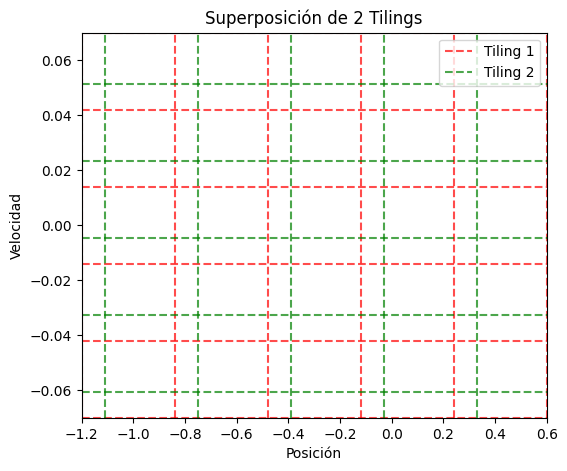

In [24]:
#@title Por ejemplo, podemos generar 2 tilings sbore el espacio $[-1.2, 0.6]\times [-0.07, 0.07]$ Cada color es un mosaico.


# Parámetros del espacio
x_min, x_max = -1.2, 0.6    # Rango para la posición
y_min, y_max = -0.07, 0.07  # Rango para la velocidad

# Número de celdas en cada dimensión y tilings
num_cells = 5       # se dividen en 5 celdas (25 posibles regiones)
num_tilings = 2     # cantidad de tilings

# Tamaño de cada celda
dx = (x_max - x_min) / num_cells
dy = (y_max - y_min) / num_cells

# Colores para cada tiling
colors = ['red', 'green', 'blue', 'orange']

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel("Posición")
ax.set_ylabel("Velocidad")
ax.set_title("Superposición de 2 Tilings")

# Dibujar cada tiling con un offset progresivo
for i in range(num_tilings):
    # Calcular el offset para este tiling (una fracción del tamaño de celda)
    offset_x = (i / num_tilings) * dx
    offset_y = (i / num_tilings) * dy

    # Calcular las posiciones de las líneas de la grilla para cada tiling.
    # Se extiende ligeramente el rango para que se vean las líneas desplazadas.
    x_lines = np.arange(x_min + offset_x/(i+1), x_max + dx, dx)
    y_lines = np.arange(y_min + offset_y-offset_y/((2*i+1)), y_max + dy, dy)

    # Dibujar líneas verticales
    for xv in x_lines:
        ax.axvline(x=xv, color=colors[i], linestyle='--', alpha=0.7, label=f'Tiling {i+1}' if xv==x_lines[0] else "")
    # Dibujar líneas horizontales
    for yv in y_lines:
        ax.axhline(y=yv, color=colors[i], linestyle='--', alpha=0.7)

# Mostrar leyenda (cada tiling se etiqueta una sola vez)
ax.legend()
plt.show()


### Creamos una Tile Coding de los estados

- Necesitamos hacer un Wrapper sobre el espacio de observaciones
- Vamos a generar algunos tilings

### Creamos el Tile Coding wrapper

In [110]:
#@title Extensión de la clase ObservationWrapper de Gymnasium para discretizar estados continuos

# https://gymnasium.farama.org/tutorials/gymnasium_basics/implementing_custom_wrappers/


# Definimos una clase que hereda de gym.ObservationWrapper, la cual nos permite modificar las observaciones que devuelve el entorno.

class TileCodingEnv(ObservationWrapper):
    """
    TileCodingEnv es un envoltorio para un entorno Gym que aplica la técnica de Tile Coding.
    Esta técnica discretiza observaciones continuas en múltiples rejillas (tilings) desplazadas,
    permitiendo representar el espacio de estados de forma que se faciliten la generalización y el aprendizaje.
    """

    def __init__(self, env, bins, low, high, n=4):
        """
        Inicializa el entorno env con tile coding.

        Parámetros:
        - env: entorno original de Gym.
        - bins: array o lista con el número de intervalos (bins) que hay que particionar cada dimensión.
        - low: array con el límite inferior para cada dimensión.
        - high: array con el límite superior para cada dimensión.
        - n: número de tilings (rejillas) a crear (por defecto 4).

        Se llama al método _create_tilings para generar las rejillas desplazadas.
        """
        super().__init__(env)  # Llama al constructor de la clase padre ObservationWrapper.
        self.tilings = self._create_tilings(bins, high, low, n)  # Crea y almacena las tilings.
        # el vector de observación tendrá C componentes. Por ejemplo, para 2 dimensiones × 4 tilings = C = 8.
        self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist()*n)

    def observation(self, obs):  # Es necesario sobreescribir este método de ObservationWrapper
        """
        Transforma una observación continua en una representación discreta usando tile coding.

        Parámetro:
        - obs: observación continua proveniente del entorno.

        Para cada tiling (rejilla) en self.tilings, se determina el índice del tile en el que
        cae cada componente de la observación mediante np.digitize. Se devuelve una lista de
        tuplas de índices, una por cada tiling.
        """
        indices = []  # Lista que almacenará los índices discretizados para cada tiling.
        for t in self.tilings:
            # Para cada tiling 't', se calcula el índice en el que se encuentra cada componente de la observación.
            tiling_indices = tuple(np.digitize(i, b) for i, b in zip(obs, t))
            indices.append(tiling_indices)  # Se agrega la tupla de índices correspondiente a la tiling actual.
        return indices  # Retorna la lista de índices de todas las tilings.

    def _create_tilings(self, bins, high, low, n):
        """
        Crea 'n' tilings (rejillas) desplazadas para el tile coding.

        Parámetros:
        - bins: número de intervalos (bins) en cada dimensión.
        - high: array con el límite superior para cada dimensión.
        - low: array con el límite inferior para cada dimensión.
        - n: número de tilings a crear.

        El proceso consiste en:
         1. Generar un vector de desplazamientos base (displacement_vector) para cada dimensión.
         2. Para cada tiling, se ajustan los límites 'low' y 'high' añadiéndoles un pequeño desplazamiento aleatorio.
         3. Se calculan los tamaños de los segmentos en cada dimensión (segment_sizes).
         4. Se determinan desplazamientos específicos para cada dimensión y se aplican a los límites.
         5. Finalmente, se generan los buckets (límites discretos) para cada dimensión usando np.linspace.

        Retorna:
        - tilings: una lista donde cada elemento es una tiling (lista de arrays de buckets para cada dimensión).
        """
        # Se genera un vector de desplazamientos en cada dimensión en base a los números impares.
        # P.e. Si hay 2 dimensiones (len(bins) == 2): np.arange(1, 2 * 2, 2) -> np.arange(1, 4, 2) devuelve [1, 3]
        #      Si la dimensión 1 se desplaza en 1 unidad, en la dimensión 2 se desplazará en 3 unidades.
        # P.e. Si hay 3 dimensiones (len(bins) == 3): np.arange(1, 2 * 3, 2) -> np.arange(1, 6, 2) devuelve [1, 3, 5]
        # P.e. Si hay 4 dimensiones (len(bins) == 4): np.arange(1, 2 * 4, 2) -> np.arange(1, 8, 2) devuelve [1, 3, 5, 7]
        # Y así sucesivamente.
        # displacement_vector se ajusta automáticamente generando un array de números impares
        # Estos valores se usan posteriormente para calcular los desplazamientos específicos en cada dimensión al crear las tilings (rejillas).
        # ¿Por qué esos valores? Porque son los recomendados: los primeros números impares.
        displacement_vector = np.arange(1, 2 * len(bins), 2)


        tilings = []  # Lista que almacenará todas las tilings generadas.
        for i in range(1, n + 1):
            # Para cada tiling 'i', se calculan nuevos límites 'low_i' y 'high_i' con un desplazamiento aleatorio.
            # El desplazamiento aleatorio se basa en el 20% de los límites originales.
            low_i = low - random.random() * 0.2 * low
            high_i = high + random.random() * 0.2 * high

            # Vamos a calcular el desplazamiento específico para cada dimensión y cada mosaico.

            # Antes calculamos displacement_vector, que nos indica el desplazamiento en cada dimensión.
            # Como tenemos varios mosaicos, cada uno se tendrá que desplazar
            # en la mismas cantidades con respecto al mosaico anterior.
            # Esto se puede conseguir multiplicando el displacement_vector por el número de mosaico (i),
            # pero se toma el módulo n (número total de mosaicos).
            # De esta forma el desplazamiento de cada mosaico es diferente, dentro del rango [0, n-1]

            # P.e. Para n=4 mosaicos, y dos dimensiones, los vectores de desplazamiento de cada mosaico son:
            # i = 1: [1, 3] = [1, 3] * 1 % 4 = [1, 3] % 4
            # i = 2: [2, 2] = [1, 3] * 2 % 4 = [2, 6] % 4
            # i = 3: [3, 1] = [1, 3] * 3 % 4 = [3, 9] % 4
            # i = 4: [0, 0] = [1, 3] * 4 % 4 = [4, 12] % 4
            displacements = displacement_vector * i % n

            # Pero hay que escalar el desplazamiento a unidades reales en cada dimensión.
            # Para ello necesitamos calcular el tamaño de cada segmento (intervalo) en cada dimensión.
            segment_sizes = (high_i - low_i) / bins

            # Entonces usamos una fracción del tamaño del segmento para desplazar cada mosaico.
            # La fracción del tamaño del segmento viene dado por el tamaño del segmento dividido por el número de mosaicos.
            # Por ejemplo, si el tamaño de la celda es 0.5 en la primera dimensión y se consideran n=4 mosaicos, la fracción es 0.5/4=0.125
            # Según se ha calculado anteriormente, en el vector de desplazamiento,
            # la primera dimensión se desplaza en 1, 2, 3 y 0 unidades para los mosaicos 1, 2, 3, y 4, respectivamente.
            # Como la unidad es 0.125, entonces la primera dimensión de cada mosaico se desplaza en las cantidades:
            # 0.125 = 1 * 0.125,  0.25 = 2 * 0.125, 0.375 = 3 * 0.125, y  0 = 0 * 0.125.
            # Lo mismo se haría con el resto de dimensiones. En forma vectorial:
            # Es decir, el desplazamiento de cada mosaico en la primera dimensión es:
            # Tiling 1, [1, 3]: [1 * 0.125, 3 * 0.05] = [0.125, 0.15]
            # Tiling 2, [2, 2]: [2 * 0.125, 2 * 0.05] = [0.25, 0.10]
            # Tiling 3, [3, 1]: [3 * 0.125, 1 * 0.05] = [0.375, 0.05]
            # Tiling 4  [0, 0]: [0 * 0.125, 0 * 0.05] = [0, 0]
            displacements = displacements * (segment_sizes / n)

            # Se aplican los desplazamientos a los límites inferiores y superiores.
            low_i += displacements
            high_i += displacements

            # Para cada dimensión, se crean los buckets que dividen el intervalo de low_i a high_i en 'bins' partes,
            # generando 'l-1' puntos (límites) para cada dimensión.
            buckets_i = [np.linspace(j, k, l - 1) for j, k, l in zip(low_i, high_i, bins)]

            # Se añade la tiling actual (lista de buckets para cada dimensión) a la lista de tilings.
            tilings.append(buckets_i)

        return tilings  # Retorna la lista completa de tilings.

In [118]:
#@title Generamos 4 mosaicos (tilings) con 20x20 intervalos. Al nuevo espacio lo llamaremos *tcenv*
tilings = 4
bins = np.array([20, 20])
low = env.observation_space.low
high = env.observation_space.high
tcenv = TileCodingEnv(env, bins=bins, low=low, high=high, n=tilings)

([(6, 8), (6, 8), (6, 9), (7, 9)], {})

### Comparamos el entorno original con el entorno con estados agregados

In [121]:
print(f"El espacio de observaciones original es: {env.observation_space}, \n\
Un estado para este espacio es: {env.step(env.action_space.sample())}")
print(f"El espacio de estados modificado es: {tcenv.observation_space}, \n\
Un estado para este nuevo espacio es: {tcenv.step(tcenv.action_space.sample())[0]} \n\
Cada pareja es la 'celda' correspondiente a cada mosaico")

El espacio de observaciones original es: Box([-1.2  -0.07], [0.6  0.07], (2,), float32), 
Un estado para este espacio es: (array([-0.5477421, -0.0013848], dtype=float32), -1.0, False, False, {})
El espacio de estados modificado es: MultiDiscrete([20 20 20 20 20 20 20 20]), 
Un estado para este nuevo espacio es: [(6, 8), (6, 8), (6, 9), (7, 9)] 
Cada pareja es la 'celda' correspondiente a cada mosaico


Ya podemos trabajar con los algoritmos tabulares como SARSA o Q-Learning.


Ahora, nuestra función $Q$ es $Q(m,s,a)=Q(m,(s_1, s_2), a)$. Donde $a$ es una de las 3 posibles acciones que se puede tomar en el estado (pos, vel), $(s_1, s_2)$ son las coordenadas en cada dimensión del espacio discretizado según el mosaico $m$.

En cada mosaico, cada dimensión se ha dividido en 20 subintervalos. Queremos la siguiente tabla de valores Q

|Mosaico | Posición | Velocidad | Acción | Q(m, s, a) |
|--------|--------|-----------|--------|----- |
| 1  | 1  | 1 | 0 | Q(1,1,1,0) |
| 1  | 1  | 1 | 1 | Q(1,1,1,1) |
| 1  | 1  | 1 | 2 | Q(1,1,1,2) |
| |..| .. | |
4 | 20 | 20 | 2 | Q(4,20,20,2) |


La tabla de valores inicial, para este caso, sería:

```
mosaicos = 4
action_values_Q = np.zeros((mosaicos, 20,20, 3))
```



Para conocer el resultado de una acción:
```
next_state, reward, done, _, _ = tcenv.step(action)
```

Este resultado lo podremos usar, por ejemplo, para SARSA. Para cada mosaico $k=1, 2, ..$ actualizamos su función Q como:

```
qsa = action_values_Q[k][state][action]
next_qsa = action_values_Q[k][next_state][next_action]
action_values_Q[k][state][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
```


En cuanto a cómo elegir la acción a tomar se puede usar el siguiente código:

```
def policy(state, epsilon=0.1):
    if np.random.random() < epsilon:
        return np.random.randint(3) # Selecciona una acción al azar
    else:
        av_list = []
        for k, idx in enumerate(state):
            av = action_values[k][idx]
            av_list.append(av)

        av = np.mean(av_list, axis=0)
        return np.random.choice(np.flatnonzero(av==av.max()))
```

`av_list` es una lista de la forma `av_list=[[1.0, 2.0, 3.0], [3.0, 2.0, 3.0], ...]` con tantos elementos como mosaicos haya.

`np.mean(av_list, axis=0)` calcula la media de los valores `Q`. Por ejemplo: `[(1.0+3.0)/2, (2.0+2.0)/2, (3.0+3.0)/2]`.


`np.random.choice()` elige un índice al azar, si hubiera varios, que se correspondan con los valores de acción máximos (en media).



## Bibliografía

[[1] Reinforcement Learning: An Introduction. Section 9.5.4: Tile Coding](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)